In [1]:
# Our standard imports for maths and basic methodology
import numpy as np
from sklearn.model_selection import train_test_split

# For user feedback
from tqdm import tqdm
import matplotlib.pyplot as plt

# Imports for pytorch
import torch
import torch.nn as nn

In [2]:
# Using Dataset and Data loader from pytorch.utils
from torch.utils.data import Dataset, DataLoader

class Dataload(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = torch.LongTensor(self.X[idx])
        y = torch.LongTensor(self.y[idx])
        return x, y

In [3]:
from conllu import parse_incr
'''
Here I preprocessed UD treebanks conllu files for both morphologically simple lanuguages, 
English and Swedish, and morphologically complex language, Korean.

'''
class PosDataset:
    """ Universial Dependency dataset """

    def __init__(self):
        
        self.vocab_size = None 
        self.max_sentence_length = None
        self.padding_idx = 0
        self.tagset_size = None
        self.token2idx = None
        self.tag2idx = None 
        
        #original dataset 
        self.english = []
        self.swedish = []
        self.korean = []
        
        
        # appending english treebank 
        eng_file1 = parse_incr(open("./ud-treebanks-v2.7/UD_English-EWT/en_ewt-ud-dev.conllu", 'r', encoding='utf-8'))
        eng_file2 = parse_incr(open("./ud-treebanks-v2.7/UD_English-EWT/en_ewt-ud-train.conllu", 'r', encoding='utf-8'))
        eng_file3 = parse_incr(open("./ud-treebanks-v2.7/UD_English-EWT/en_ewt-ud-test.conllu", 'r', encoding='utf-8'))
        
        for tokenlist in eng_file1:
            self.english.append(tokenlist)
        for tokenlist in eng_file2:
            self.english.append(tokenlist)
        for tokenlist in eng_file3:
            self.english.append(tokenlist)
        
        # appending swedish treebank     
        swe_file1 = parse_incr(open("./ud-treebanks-v2.7/UD_Swedish-LinES/sv_lines-ud-dev.conllu", 'r', encoding='utf-8'))
        swe_file2 = parse_incr(open("./ud-treebanks-v2.7/UD_Swedish-LinES/sv_lines-ud-train.conllu", 'r', encoding='utf-8'))
        swe_file3 = parse_incr(open("./ud-treebanks-v2.7/UD_Swedish-LinES/sv_lines-ud-test.conllu", 'r', encoding='utf-8'))
        
        for tokenlist in swe_file1:
            self.swedish.append(tokenlist)
        for tokenlist in swe_file2:
            self.swedish.append(tokenlist)
        for tokenlist in swe_file3:
            self.swedish.append(tokenlist)
        
        # appending korean treebank 
        kor_file1 = parse_incr(open("./ud-treebanks-v2.7/UD_Korean-GSD/ko_gsd-ud-dev.conllu", 'r', encoding='utf-8'))
        kor_file2 = parse_incr(open("./ud-treebanks-v2.7/UD_Korean-GSD/ko_gsd-ud-train.conllu", 'r', encoding='utf-8'))
        kor_file3 = parse_incr(open("./ud-treebanks-v2.7/UD_Korean-GSD/ko_gsd-ud-test.conllu", 'r', encoding='utf-8'))
        
        for tokenlist in kor_file1:
            self.korean.append(tokenlist)
        for tokenlist in kor_file2:
            self.korean.append(tokenlist)
        for tokenlist in kor_file3:
            self.korean.append(tokenlist)
            
        # cleaning dataset in the form of (word, upos, xpos) 
        # I added xpos to compare performance between UD and language specific tags. 
        self.english_data = [[] for i in range(len(self.english))]
        self.swedish_data = [[] for i in range(len(self.swedish))]
        self.korean_data = [[] for i in range(len(self.korean))]
        
        for i in range(len(self.english)):
            for j in range(len(self.english[i])):
                self.english_data[i].append((self.english[i][j]['form'], self.english[i][j]['upos'], self.english[i][j]['xpos']))
                
        for i in range(len(self.swedish)):
            for j in range(len(self.swedish[i])):
                self.swedish_data[i].append((self.swedish[i][j]['form'], self.swedish[i][j]['upos'], self.swedish[i][j]['xpos']))       
            
        for i in range(len(self.korean)):
            for j in range(len(self.korean[i])):
                self.korean_data[i].append((self.korean[i][j]['form'], self.korean[i][j]['upos'], self.korean[i][j]['xpos']))        
                
                
    def preprocessing(self, data, number=1): # number 1: using upos number 2: using xpos
        X = [[token for token, tag1, tag2 in sentence] for sentence in data]
        
        if number == 1:
            y = [[tag1 for token, tag1, tag2 in sentence] for sentence in data]   # using upos
        elif number == 2:
            y = [[tag2 for token, tag1, tag2 in sentence] for sentence in data]   # using xpos
        else:
            print('number should be either 1 or 2.')
            
        #making tagset 
        tags = {tag for tags in y for tag in tags}
        idx2tag = list(tags)
        idx2tag.insert(0, '<PAD>')
        idx2tag.insert(1, '<UNK>')
        tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}
        self.tag2idx = tag2idx 
        self.tagset_size = len(tag2idx) # including padding token
        
        return X, y
    
    # The function produces the sentence length plot to decide the padding size
    def sent_len(self, X):
        print(f'Maximum length : {max(len(x) for x in X)}')
        print(f'Average length : {sum(map(len, X))/len(X)} ')
        l = np.asarray([len(x) for x in X], dtype=np.int)
        plt.figure(figsize=(8, 4))
        x = np.unique(l)
        plt.bar(x, [np.sum(l==e) for e in x], width=1)
        plt.xlabel('Sentence length')
        plt.ylabel('# sentences')
        plt.show()
                
    # This function splits data into train/test data with the 0.8/0.2 ratio. 
    def data_split(self, X, y):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
        
        assert len(X_train) == len(y_train)
        assert len(X_test) == len(y_test)
        assert len(X_train)+len(X_test) == len(X)
        
        print(f"Total set includes {len(X)} sentences. ")
        print(f"The training set includes {len(X_train)} sentences.")
        print(f"The test set includes {len(X_test)} sentences.")
        
        return X_train, X_test, y_train, y_test
    
    # This function encodes the words and inserts the padding index. Since I will use max_length for the padding, I will not use unknown token. 
    def make_token(self, X , y):
        #word vocab
        tokens = {token for sentence in X for token in sentence}
        idx2token = list(tokens)
        idx2token.insert(0, '<PAD>') # padding token will always be 0
        idx2token.insert(1, '<UNK>')
        
        #storing vocab_size 
        self.vocab_size = len(idx2token)
        token2idx = {token:idx for idx, token in enumerate(idx2token)}
        self.token2idx = token2idx 


    def encode_and_pad(self, X, y):
        
        assert len(X) == len(y)
        assert np.all([len(X)==len(y) for sentence, tags in zip(X, y)])

        # storing sentence length 
        self.max_sentence_length = np.max([len(sentence) for sentence in X])
        
        padded_sentences = torch.zeros(len(X), self.max_sentence_length, dtype=torch.long)
        padded_labels = torch.zeros(len(X), self.max_sentence_length, dtype=torch.long)
        padded_sentences[:] = self.padding_idx
        padded_labels[:] = self.padding_idx
        
        for i, (sentence, tags) in enumerate(zip(X, y)):
            for j, token in enumerate(sentence):
                if token in self.token2idx.keys():
                    padded_sentences[i, j] = self.token2idx[token]                   
                else:
                    padded_sentences[i, j] = 1
                    
            for j, tag in enumerate(tags):
                try:
                    padded_labels[i, j] = self.tag2idx[tag]
                except KeyError:
                    print(tag)
    
        return padded_sentences, padded_labels
    
    
    
    def batch_iterator(self, sentences, labels, batch_size):
        
        X, y = self.encode_and_pad(sentences, labels)
        dataset = Dataload(X, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        assert len(sentences) == len(labels)

        return dataloader

## English treebanks (UD Tagsets)

- __English UD POS Data preparation__ \
    For the English treebank data, I'm going to use the maximum sentence length 160 to encode/pad the words. 
    I set padding token as 0 for both words and tag data and unknown token as 1. 
    Train/test data set will be divided into 80/20 ratio. The tagset size including padding/unknown token is 20. The vocab size for the training data is 22328. 

Maximum length : 160
Average length : 15.519191433040548 


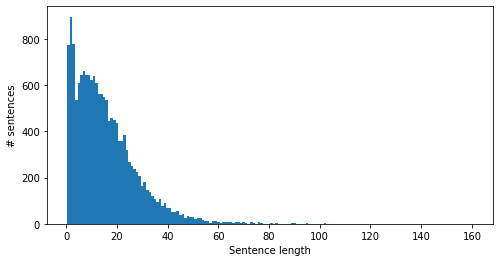

None
Total set includes 16622 sentences. 
The training set includes 14959 sentences.
The test set includes 1663 sentences.


In [4]:
english = PosDataset()
X, y = english.preprocessing(english.english_data)
print(english.sent_len(X))
x_train, x_test, y_train, y_test = english.data_split(X, y)
BATCH_SIZE = 256 
english.make_token(x_train, y_train)
train_batch_iterator = english.batch_iterator(x_train, y_train, BATCH_SIZE)

In [5]:
print("Max sentence length for the train data : ", english.max_sentence_length)
print("Vocabulary size for the train data : ", english.vocab_size)
print("Tag set data size (inc.padding idx) : ", english.tagset_size)

Max sentence length for the train data :  160
Vocabulary size for the train data :  22329
Tag set data size (inc.padding idx) :  20


## Baseline model : basic LSTM   
Baseline model that I'm going to compare with others is basic _LSTM_ without any parameter tuning, e.g. dropout rate or inserting gru layers. I'm going to compare the baseline with _GRU_ layer and _LSTM_ with dropout rate inserted. 

In [6]:
class LSTM(nn.Module):
    def __init__(self, word_embedding_dim, lstm_hidden_dim, vocab_size, tagset_size, padding_idx=0, rnn_lstm=True, drop_out=0): 
        # rnn_lstm : if it is true, it uses lstm layer. if it is false, it uses gru layer. 
        super(LSTM, self).__init__()
        self.rnn_lstm = rnn_lstm
        self.lstm_hidden_dim = lstm_hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = tagset_size
        self.padding_idx = padding_idx
        self.word_embedding = nn.Embedding(num_embeddings=vocab_size,
                                           embedding_dim=word_embedding_dim,
                                           padding_idx=self.padding_idx)
        # regularization- dropout
        self.drop_out = drop_out
        
        # lstm model 
        self.lstm = nn.LSTM(input_size=word_embedding_dim,
                            hidden_size=lstm_hidden_dim,
                            batch_first=True,
                            dropout=self.drop_out)
        self.fc = nn.Linear(lstm_hidden_dim, self.tagset_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        # to store loss and accuracy to plot graph 
        self.training_loss = list()
        self.training_accuracy=list()
        
        # for the model fitting
        self.loss_function = nn.NLLLoss(ignore_index=0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
       
        # GRU extension
        self.gru = nn.GRU(input_size=word_embedding_dim,
                          hidden_size=lstm_hidden_dim,
                          batch_first=True,
                          dropout=self.drop_out)
        
        
        
    def forward(self, padded_sentences):
        batch_size, max_sentence_length = padded_sentences.size()        
        embedded_sentences = self.word_embedding(padded_sentences) 
        sentence_lengths = (padded_sentences != self.padding_idx).sum(dim=1)
        sentence_lengths = sentence_lengths.long()        
        
        X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, 
                                              sentence_lengths,
                                              batch_first=True,
                                              enforce_sorted=False)

        if self.rnn_lstm == True:
            lstm_out, _ = self.lstm(X)
            X, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, 
                                                batch_first=True, 
                                                total_length=max_sentence_length)
            
        else:
            lstm_out, _ = self.gru(X)
            X, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, 
                                                batch_first=True, 
                                                total_length=max_sentence_length)
        X = X.contiguous().view(-1, self.lstm_hidden_dim)
        tag_space = self.fc(X)
        tag_scores = self.softmax(tag_space)
        tag_scores = tag_scores.view(batch_size, max_sentence_length, self.tagset_size)
        return tag_scores
    
    
    def loss_acc_plot(self):
        batch_size = BATCH_SIZE
        fig = plt.figure(figsize=(6, 4))
        ax = plt.subplot()
        ax.set_title("Plot for the (hopefully) decreasing loss over epochs")
        ax.plot(self.training_loss, 'b-')
        ax.set_ylabel("Training Loss", color='b')
        ax.set_xlabel("Epoch")
        # ax.set_yscale('log')
        ax.tick_params(axis='y', labelcolor='b')
        ax = ax.twinx()
        ax.plot(self.training_accuracy, 'r-')
        ax.set_ylabel("Accuracy [%]", color='r')
        ax.tick_params(axis='y', labelcolor='r')
        a = list(ax.axis())
        a[2] = 0
        a[3] = 100
        ax.axis(a)
        t = np.arange(0, len(model.training_accuracy), len(x_train)//batch_size+1)
        ax.set_xticks(ticks=t)
        ax.set_xticklabels(labels=np.arange(len(t)))
        fig.tight_layout()
        plt.show()
    
    
    def fit(self, 
            X, batch_iter,
            epoch = 5,
            batch_size = BATCH_SIZE):
            
        for epoch in range(epoch):
            with tqdm(batch_iter, total=len(X)//batch_size+1,
                  unit="batch",
                  desc=f"Epoch {epoch}") as batches:
                for inputs, targets in batches:
                    self.zero_grad()
                    scores = self(inputs)
                    loss = self.loss_function(scores.view(-1, self.tagset_size),
                                         targets.view(-1))
                    loss.backward()
                    self.optimizer.step()
                    predictions = scores.argmax(dim=2, keepdim=True).squeeze()
                    mask = targets!=0
                    correct = (predictions[mask] == targets[mask]).sum().item()
                    accuracy = correct / mask.sum().item() * 100
                    self.training_accuracy.append(accuracy)
                    self.training_loss.append(loss.item())
                    batches.set_postfix(loss=loss.item(), accuracy=accuracy)
                
                
            
        
    def predict(self, test_batch_iterator):
        
        with torch.no_grad():
            self.drop_out = 0 
            n_correct = 0
            n_total = 0
            for inputs, targets in test_batch_iterator: # Loop once over the test data
                scores = self(inputs)                                                      # Runs the test data through the model
                predictions = scores.argmax(dim=2, keepdim=True).squeeze()                  # Finds the predictions
                mask = targets!= 0
                n_correct += (predictions[mask] == targets[mask]).sum().item()              # Sums the number of correct predictions
                n_total += mask.sum().item()
        print(f"Test accuracy: {100 * n_correct/n_total}")
            
    

In [7]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= english.vocab_size,
                   tagset_size= english.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0)
print(model) 

LSTM(
  (word_embedding): Embedding(22329, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=20, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True)
)


In [8]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 59/59 [00:28<00:00,  2.06batch/s, accuracy=93.5, loss=0.217]


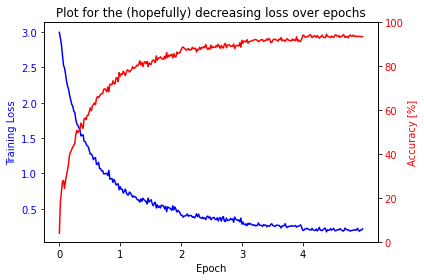

In [9]:
model.loss_acc_plot()

In [10]:
test_batch_iterator = english.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 89.32304921498766


## Expansion: GRU layers

In [11]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= english.vocab_size,
                   tagset_size= english.tagset_size,
                   rnn_lstm = False)
print(model) 

LSTM(
  (word_embedding): Embedding(22329, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=20, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True)
)


In [12]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 59/59 [00:25<00:00,  2.29batch/s, accuracy=91.2, loss=0.275]


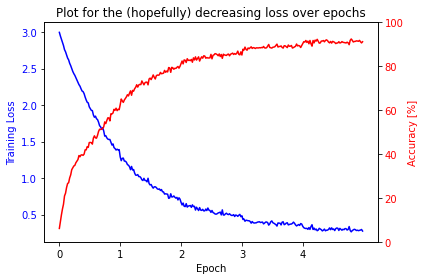

In [13]:
model.loss_acc_plot()

In [14]:
test_batch_iterator = english.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 87.73344818135547


## Expansion : LSTM with dropout rate to 0.2

In [16]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= english.vocab_size,
                   tagset_size= english.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0.2)
print(model) 

LSTM(
  (word_embedding): Embedding(22329, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=60, out_features=20, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True, dropout=0.2)
)


In [17]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 59/59 [00:28<00:00,  2.11batch/s, accuracy=94.6, loss=0.173]


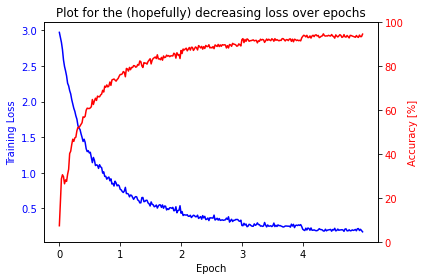

In [18]:
model.loss_acc_plot()

In [19]:
test_batch_iterator = english.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 89.18209936964097


# Swedish treebanks (UD Dataset)

- __Swedish UD POS Data preparation__ \
    For the Swedish treebank data, I'm going to use the maximum sentence length 96 to encode/pad the words. 
    I set padding token as 0 for both words and tag data and unknown token as 1. 
    Train/test data set will be divided into 80/20 ratio. The tagset size including padding/unknown token is 20. The vocab size for the training data is 14049. 

Maximum length : 96
Average length : 17.34884608048827 


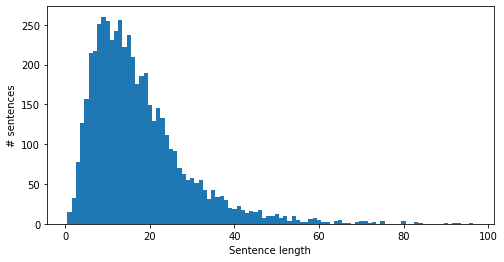

None
Total set includes 5243 sentences. 
The training set includes 4718 sentences.
The test set includes 525 sentences.


In [20]:
swedish = PosDataset()
X, y = swedish.preprocessing(swedish.swedish_data)
print(swedish.sent_len(X))
x_train, x_test, y_train, y_test = swedish.data_split(X, y)
BATCH_SIZE = 256 
swedish.make_token(x_train, y_train)
train_batch_iterator = swedish.batch_iterator(x_train, y_train, BATCH_SIZE)

In [29]:
print("Max sentence length for the train data : ", swedish.max_sentence_length)
print("Vocabulary size for the train data : ", swedish.vocab_size)
print("Tag set data size (inc.padding idx) : ", swedish.tagset_size)

Max sentence length for the train data :  96
Vocabulary size for the train data :  14049
Tag set data size (inc.padding idx) :  19


## Baseline model : basic LSTM   

In [21]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= swedish.vocab_size,
                   tagset_size= swedish.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0)
print(model) 

LSTM(
  (word_embedding): Embedding(14049, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=19, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True)
)


In [22]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 19/19 [00:08<00:00,  2.37batch/s, accuracy=88.2, loss=0.383]


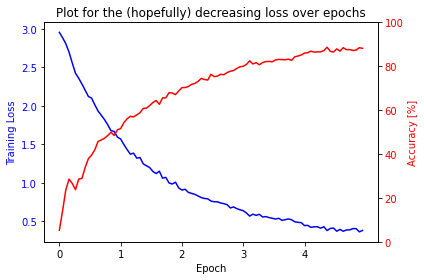

In [23]:
model.loss_acc_plot()

In [24]:
test_batch_iterator = swedish.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 82.14670981661273


## Expansion: GRU layers

In [25]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= swedish.vocab_size,
                   tagset_size= swedish.tagset_size,
                   rnn_lstm = False,
                   drop_out= 0)
print(model) 

LSTM(
  (word_embedding): Embedding(14049, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=19, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True)
)


In [26]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 19/19 [00:06<00:00,  2.92batch/s, accuracy=82.1, loss=0.665]


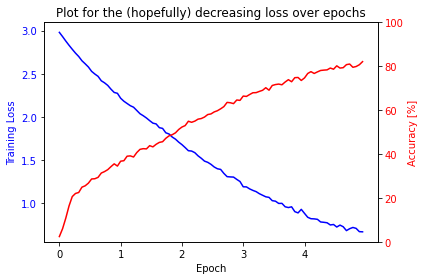

In [27]:
model.loss_acc_plot()

In [28]:
test_batch_iterator = swedish.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 75.51240560949299


## Expansion: LSTM with dropout rate to 0.2  

In [29]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= swedish.vocab_size,
                   tagset_size= swedish.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0.2)
print(model) 

LSTM(
  (word_embedding): Embedding(14049, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=60, out_features=19, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True, dropout=0.2)
)


In [30]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 19/19 [00:07<00:00,  2.56batch/s, accuracy=88.7, loss=0.383]


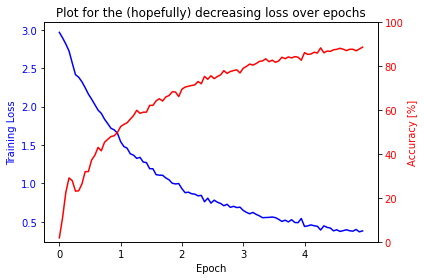

In [31]:
model.loss_acc_plot()

In [32]:
test_batch_iterator = swedish.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 83.89428263214671


## Korean Treebanks (UD Dataset)

- __Korean UD POS Data preparation__ \
    For the Korean treebank data, I'm going to use the maximum sentence length 83 to encode/pad the words. 
    I set padding token as 0 for both words and tag data and unknown token as 1. 
    Train/test data set will be divided into 80/20 ratio. The tagset size including padding/unknown token is 20. The vocab size for the training data is 33159. 

Maximum length : 83
Average length : 12.671083767155702 


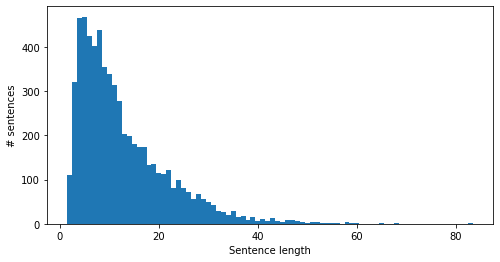

None
Total set includes 6339 sentences. 
The training set includes 5705 sentences.
The test set includes 634 sentences.


In [33]:
korean = PosDataset()
X, y = korean.preprocessing(korean.korean_data)
print(korean.sent_len(X))
x_train, x_test, y_train, y_test = korean.data_split(X, y)
BATCH_SIZE = 256 
korean.make_token(x_train, y_train)
train_batch_iterator = korean.batch_iterator(x_train, y_train, BATCH_SIZE)

In [34]:
print("Max sentence length for the train data : ", korean.max_sentence_length)
print("Vocabulary size for the train data : ", korean.vocab_size)
print("Tag set data size (inc.padding idx) : ", korean.tagset_size)

Max sentence length for the train data :  83
Vocabulary size for the train data :  33159
Tag set data size (inc.padding idx) :  18


## Baseline model : basic LSTM   

In [35]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= korean.vocab_size,
                   tagset_size= korean.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0)
print(model) 

LSTM(
  (word_embedding): Embedding(33159, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True)
)


In [36]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 23/23 [00:05<00:00,  4.16batch/s, accuracy=86.3, loss=0.452]


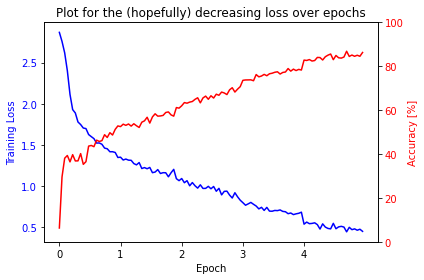

In [37]:
model.loss_acc_plot()

In [38]:
test_batch_iterator = korean.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 70.34341886888804


## Expansion: GRU layers

In [39]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= korean.vocab_size,
                   tagset_size= korean.tagset_size,
                   rnn_lstm = False,
                   drop_out= 0)
print(model) 

LSTM(
  (word_embedding): Embedding(33159, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True)
)


In [40]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 23/23 [00:04<00:00,  4.69batch/s, accuracy=74.9, loss=0.732]


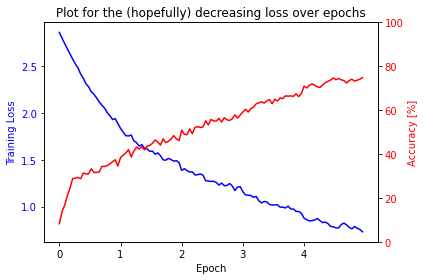

In [41]:
model.loss_acc_plot()

In [42]:
test_batch_iterator = korean.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 57.98544618919954


## Expansion: LSTM with dropout rate to 0.2  

In [45]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= korean.vocab_size,
                   tagset_size= korean.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0.3)
print(model) 

LSTM(
  (word_embedding): Embedding(33159, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=60, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True, dropout=0.3)
)


In [46]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 23/23 [00:05<00:00,  4.11batch/s, accuracy=88.3, loss=0.398]


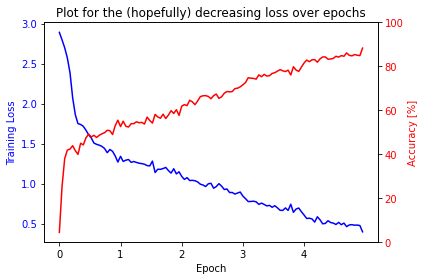

In [47]:
model.loss_acc_plot()

In [48]:
test_batch_iterator = korean.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 75.47555215115537


# English treebanks (Language specific Tagsets) 

Maximum length : 160
Average length : 15.519191433040548 


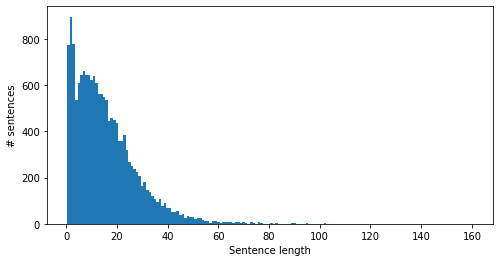

None
Total set includes 16622 sentences. 
The training set includes 14959 sentences.
The test set includes 1663 sentences.


In [49]:
english = PosDataset()
X, y = english.preprocessing(english.english_data, number=2)
print(english.sent_len(X))
x_train, x_test, y_train, y_test = english.data_split(X, y)
BATCH_SIZE = 256 
english.make_token(x_train, y_train)
train_batch_iterator = english.batch_iterator(x_train, y_train, BATCH_SIZE)

In [50]:
print("Tag set data size (inc.padding idx) : ", english.tagset_size)

Tag set data size (inc.padding idx) :  53


## Baseline Model: Basic LSTM 

In [51]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= english.vocab_size,
                   tagset_size= english.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0)
print(model) 

LSTM(
  (word_embedding): Embedding(22329, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=53, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True)
)


In [52]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 59/59 [00:27<00:00,  2.11batch/s, accuracy=93.6, loss=0.235]


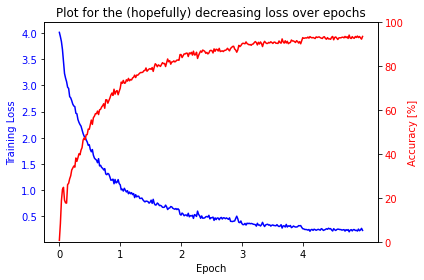

In [53]:
model.loss_acc_plot()

In [54]:
test_batch_iterator = english.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 89.03331897733057


## Extension:  GRU layers

In [55]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= english.vocab_size,
                   tagset_size= english.tagset_size,
                   rnn_lstm = False,
                   drop_out= 0)
print(model) 

LSTM(
  (word_embedding): Embedding(22329, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=53, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True)
)


In [56]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|████████████████████████████████████████████| 59/59 [00:25<00:00,  2.30batch/s, accuracy=89.6, loss=0.34]


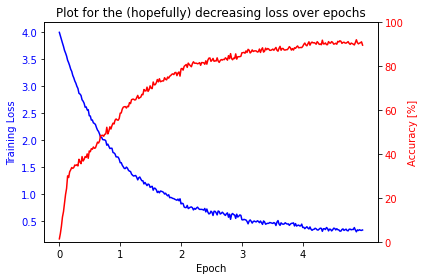

In [57]:
model.loss_acc_plot()

In [58]:
test_batch_iterator = english.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 87.22837790219647


## Extension:  dropout rate 

In [59]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= english.vocab_size,
                   tagset_size= english.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0.2)
print(model) 

LSTM(
  (word_embedding): Embedding(22329, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=60, out_features=53, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True, dropout=0.2)
)


In [60]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 59/59 [00:27<00:00,  2.15batch/s, accuracy=92.7, loss=0.246]


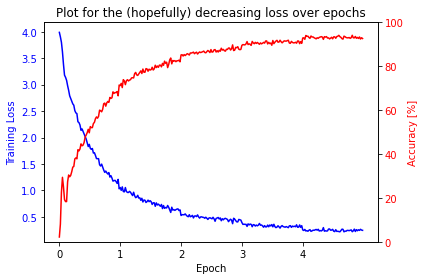

In [61]:
model.loss_acc_plot()

In [62]:
test_batch_iterator = english.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 89.32696448846951


# Swedish treebanks (Language specific Tagsets) 

Maximum length : 96
Average length : 17.34884608048827 


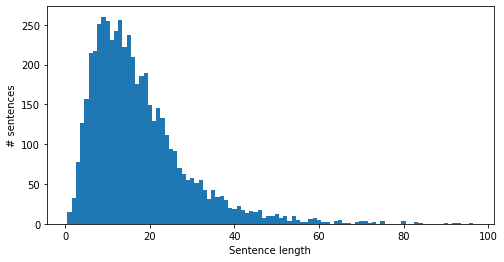

None
Total set includes 5243 sentences. 
The training set includes 4718 sentences.
The test set includes 525 sentences.


In [63]:
swedish = PosDataset()
X, y = swedish.preprocessing(swedish.swedish_data, number=2)
print(swedish.sent_len(X))
x_train, x_test, y_train, y_test = swedish.data_split(X, y)
BATCH_SIZE = 256 
swedish.make_token(x_train, y_train)
train_batch_iterator = swedish.batch_iterator(x_train, y_train, BATCH_SIZE)

In [64]:
print("Tag set data size (inc.padding idx) : ", swedish.tagset_size)

Tag set data size (inc.padding idx) :  240


## Baseline Model: Basic LSTM 

In [65]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= swedish.vocab_size,
                   tagset_size= swedish.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0)
print(model) 

LSTM(
  (word_embedding): Embedding(14049, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=240, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True)
)


In [66]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|████████████████████████████████████████████| 19/19 [00:08<00:00,  2.23batch/s, accuracy=77.6, loss=0.92]


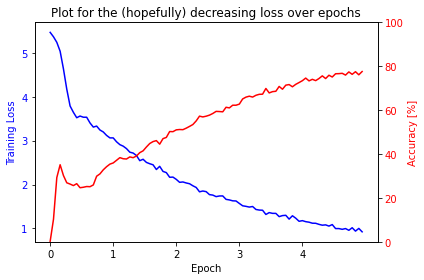

In [67]:
model.loss_acc_plot()

In [68]:
test_batch_iterator = swedish.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 74.39050701186623


## Extension:  GRU layers

In [69]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= swedish.vocab_size,
                   tagset_size= swedish.tagset_size,
                   rnn_lstm = False,
                   drop_out= 0)
print(model) 

LSTM(
  (word_embedding): Embedding(14049, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=240, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True)
)


In [70]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|████████████████████████████████████████████| 19/19 [00:07<00:00,  2.50batch/s, accuracy=70.3, loss=1.25]


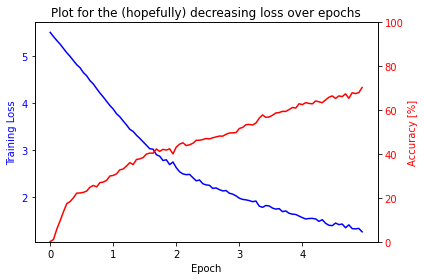

In [71]:
model.loss_acc_plot()

In [72]:
test_batch_iterator = swedish.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 66.04099244875944


## Extension:  dropout rate

In [73]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= swedish.vocab_size,
                   tagset_size= swedish.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0.2)
print(model) 

LSTM(
  (word_embedding): Embedding(14049, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=60, out_features=240, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True, dropout=0.2)
)


In [74]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 19/19 [00:08<00:00,  2.14batch/s, accuracy=76.9, loss=0.923]


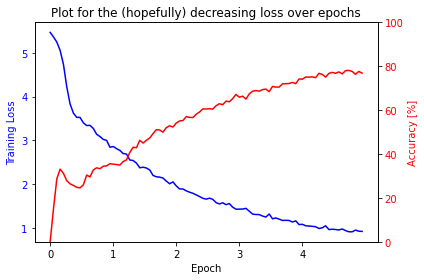

In [75]:
model.loss_acc_plot()

In [76]:
test_batch_iterator = swedish.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 75.35059331175836


# Korean treebanks (Language specific Tagsets) 

Maximum length : 83
Average length : 12.671083767155702 


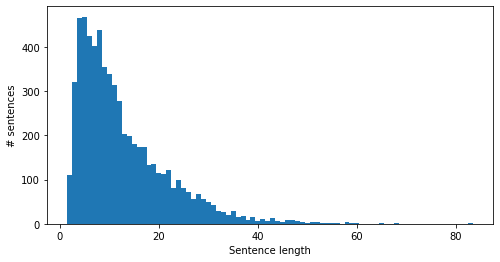

None
Total set includes 6339 sentences. 
The training set includes 5705 sentences.
The test set includes 634 sentences.


In [77]:
korean = PosDataset()
X, y = korean.preprocessing(korean.korean_data, number=2)
print(korean.sent_len(X))
x_train, x_test, y_train, y_test = korean.data_split(X, y)
BATCH_SIZE = 256 
korean.make_token(x_train, y_train)
train_batch_iterator = korean.batch_iterator(x_train, y_train, BATCH_SIZE)

In [78]:
print("Tag set data size (inc.padding idx) : ", korean.tagset_size)

Tag set data size (inc.padding idx) :  1256


In [79]:
## Baseline Model: Basic LSTM 

In [80]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= korean.vocab_size,
                   tagset_size= korean.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0)
print(model) 

LSTM(
  (word_embedding): Embedding(33159, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=1256, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True)
)


In [81]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|████████████████████████████████████████████| 23/23 [00:12<00:00,  1.91batch/s, accuracy=46.6, loss=2.47]


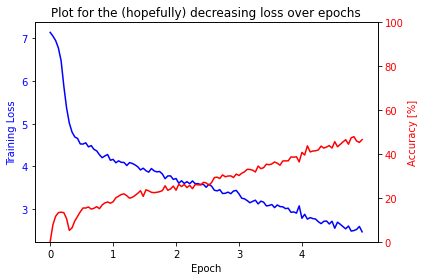

In [82]:
model.loss_acc_plot()

In [83]:
test_batch_iterator = korean.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 45.142346482829055


In [84]:
## Extension:  GRU layers

In [85]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= korean.vocab_size,
                   tagset_size= korean.tagset_size,
                   rnn_lstm = False,
                   drop_out= 0)
print(model) 

LSTM(
  (word_embedding): Embedding(33159, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=1256, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True)
)


In [86]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|████████████████████████████████████████████| 23/23 [00:12<00:00,  1.89batch/s, accuracy=38.3, loss=2.89]


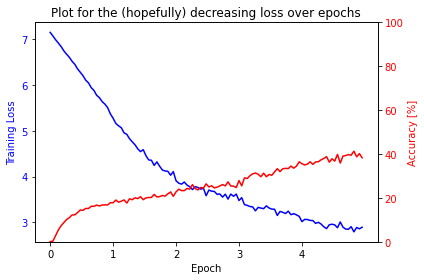

In [87]:
model.loss_acc_plot()

In [88]:
test_batch_iterator = korean.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 37.04838503766118


In [89]:
## Extension:  dropout rate

In [90]:
model = LSTM(word_embedding_dim=32,
                   lstm_hidden_dim=60,
                   vocab_size= korean.vocab_size,
                   tagset_size= korean.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0.2)
print(model) 

LSTM(
  (word_embedding): Embedding(33159, 32, padding_idx=0)
  (lstm): LSTM(32, 60, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=60, out_features=1256, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(32, 60, batch_first=True, dropout=0.2)
)


In [91]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|████████████████████████████████████████████| 23/23 [00:12<00:00,  1.88batch/s, accuracy=49.4, loss=2.58]


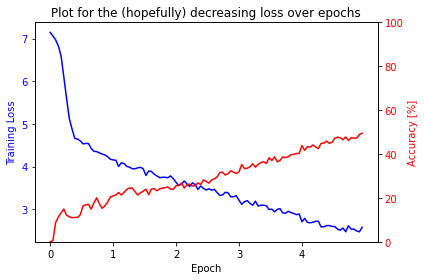

In [92]:
model.loss_acc_plot()

In [39]:
test_batch_iterator = korean.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 46.17643303970382


## Korean LS data with larger embedding dimension and hidden dimension

In [93]:
model = LSTM(word_embedding_dim=128,
                   lstm_hidden_dim=240,
                   vocab_size= korean.vocab_size,
                   tagset_size= korean.tagset_size,
                   rnn_lstm = True,
                   drop_out= 0.2)
print(model) 

LSTM(
  (word_embedding): Embedding(33159, 128, padding_idx=0)
  (lstm): LSTM(128, 240, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=240, out_features=1256, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss_function): NLLLoss()
  (gru): GRU(128, 240, batch_first=True, dropout=0.2)
)


In [94]:
model.fit(x_train, train_batch_iterator)

Epoch 4: 100%|███████████████████████████████████████████| 23/23 [00:32<00:00,  1.42s/batch, accuracy=78.8, loss=0.898]


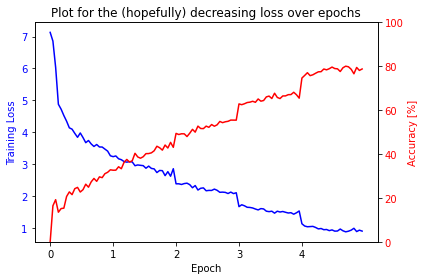

In [95]:
model.loss_acc_plot()

In [96]:
test_batch_iterator = korean.batch_iterator(x_test, y_test, batch_size=BATCH_SIZE)
model.predict(test_batch_iterator)

Test accuracy: 57.98544618919954


# Final Analysis

################################################################################
- __Extension:__ \
    (1)	Add the option to use a GRU layer instead of LSTM \
    (2)	Implement some level of regularization in your model. (dropout) \
    (3)	Compare performace using UD's universal vs language specific tag sets. \
    (4)	Use pyTorch's Dataset and DataLoader classes for loading the data.  \

################################################################################    


__1. Extension 1, 2, and 3 Analysis__

1.1 UD tag set evaluation 

For the RNN based POS tagger, three languages are used: English, Swedish, and Korean. English and Swedish are morphologically simpler language compared to Korean. I assumed the quality of performance between both English/Swedish and Korean would differ by a large margin. 

|                     |     Basic   LSTM     |     GRU   layer      |     LSTM   (dropout=0.2)    |
|---------------------|----------------------|----------------------|-----------------------------|
|     English   UD    |     93.5   / 89.4    |     91.2   / 87.7    |     94.6   / 89.2           |
|     Swedish   UD    |     88.2   / 82.1    |     82.1   / 75.5    |     88.7   / 83.9           |
|     Korean   UD     |     86.3   / 70.3    |     74.9   / 58.0    |     88.3   / 75.5           |

Table 1. Train/test accuracy according to the three model frameworks for three UD language tag datasets

As shown above, baseline model, LSTM without any tuning showed strong performance compared to GRU layers. To get the better result, I explored various drop out rate ranging from 0.1 to 0.3. Drop out rate 0.2 showed the best result on most of the UD/ Language specific (LS) data sets.   
Compared to English/Swedish, Korean UD showed lower accuracy on every case. The reason is because POS in Korean is not clearly divided by the spacing, which is similar to Finnish or Hungarian in terms of morphological system. To distinguish POS, deeper morpheme tokenization is necessary. So, the model would find hard to learn the clear pattern as much as English or Swedish.    


2.2 LS (language specific) tag sets evaluation__ 

|                     |     Basic   LSTM     |     GRU   layer      |     LSTM   (dropout=0.2)    |
|---------------------|----------------------|----------------------|-----------------------------|
|     English   LS    |     93.6   / 89.0    |     89.6   / 87.2    |     92.7   / 89.3           |
|     Swedish   LS    |     77.6   / 74.4    |     70.3   / 66.0    |     76.9   / 75.4           |
|     Korean   LS     |     46.6   / 45.1    |     38.3   / 37.0    |     49.4   / 46.1           |

Table 2. Train/test accuracy according to the three model frameworks for three LS language tag datasets

As shown in Table 2 above, baseline model also showed good result even though the accuracy rate had been severely dropped than UD dataset. Compared to the other datasets, English LS data set showed the least change due to the large size of the data and the smallest POS tag sets (size of 53 including padding/unknown index).  Compared to English, both languages had very small size of data, Swedish tag set size was 240 and Korean with 1256 tag sets, as an extreme case. As Korean requires higher model complexity, I tried with higher word embedding dimensionality (128) and hidden dimensionality (240). Compared to the best train/test accuracy Korean data showed (train: 49.4/test: 46.1 with LSTM, drop out = 0.2), training accuracy increased up to 78.8 and test accuracy to 58.0.    

__2. Extension 4__ 

Extension 4 is implemented above. 

__3. Hardest part of the assignment__

The hardest part was definitely to understand the torch framework, which felt unfamiliar for me at first. I spent many hours trying to figure out the errors resulted from unmatched size/shape in the process of the data feeding into the lstm network.  However, it was quite simple to train the model and get the result as soon as the data was in the right shape. 

